In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms,models
from torch.utils.data import DataLoader, TensorDataset, random_split,Dataset
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from torchsummary import summary
import numpy as np
import torch.nn.functional as F
from scipy.io import loadmat
from PIL import Image
from torchvision.utils import make_grid


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### Setup and data loading

In [3]:
transform_train = transforms.Compose([
    transforms.RandAugment(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [4]:
phase = 'test'
root = r'standford'
root_images = f'{root}/Images'

mat_file = loadmat(f'{root}/{phase}_list.mat')
# mat_file['file_list'], mat_file['labels']

file_list = mat_file['file_list']
images_list = [f'{root_images}/{file_[0][0]}' for file_ in file_list]

labels = torch.LongTensor(mat_file['labels']).squeeze() - 1


### Custom Dataset

In [5]:
class StanfordDogs(Dataset):

  def __init__(self, root, phase, transform):
    self.transform = transform
    
    root_images = f'{root}/Images'

    mat_file = loadmat(f'{root}/{phase}_list.mat')

    file_list = mat_file['file_list']
    self.images_list = [f'{root_images}/{file_[0][0]}' for file_ in file_list]

    self.labels = torch.LongTensor(mat_file['labels']).squeeze() - 1

  def __getitem__(self, item):
    image_path = self.images_list[item]
    img = Image.open(image_path).convert('RGB')
    img = self.transform(img)
    label = self.labels[item].item()
    return img, label

  def __len__(self):
    return len(self.labels)

In [6]:
train_set = StanfordDogs(root = r'standford',
                        phase='train',
                        transform=transform_train)

test_set = StanfordDogs(root = r'standford',
                        phase='test',
                        transform=transform_test)

In [7]:
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=True)

In [8]:
train_set.images_list
train_set.labels
len(train_set)
train_set.__len__()

12000

In [9]:
train_set[5000][0].shape

torch.Size([3, 224, 224])

### Visualizing the data

In [10]:
x, y = next(iter(train_loader))
x.shape, y

(torch.Size([64, 3, 224, 224]),
 tensor([ 73,  65,  40, 103,  33,  43,  44, 101,  96,  61,  84,  39,   9,  31,
          18,  35,  13, 112,  54,  85,  42, 118, 118,  84,  11,  77,  50,  38,
          83,  42,  70,  37,  31,  11, 115, 109,   0,   2,  26,  80,  63,   8,
          83,  78,  35,  19, 100,  36,  13,  41,  56,  62,  13,   4,  67,  17,
          81,  32,  26, 102, 113,  26,  36,  19]))

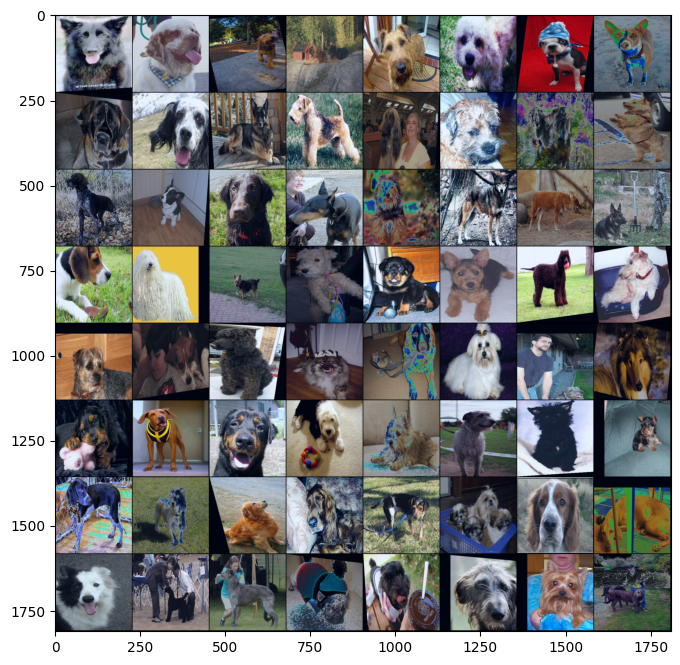

In [11]:
img_grid = make_grid(x, nrow=8, normalize=True).permute(1, 2, 0)

plt.figure(figsize=(16, 8))
plt.imshow(img_grid)

### Data augmentation

In [12]:

transform_train = transforms.Compose([
    transforms.RandAugment(),
    transforms.Resize((224, 224)),
    transforms.RandomRotation(degrees=15),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [13]:
train_set = StanfordDogs(root = r'standford',
                        phase='train',
                        transform=transform_train)


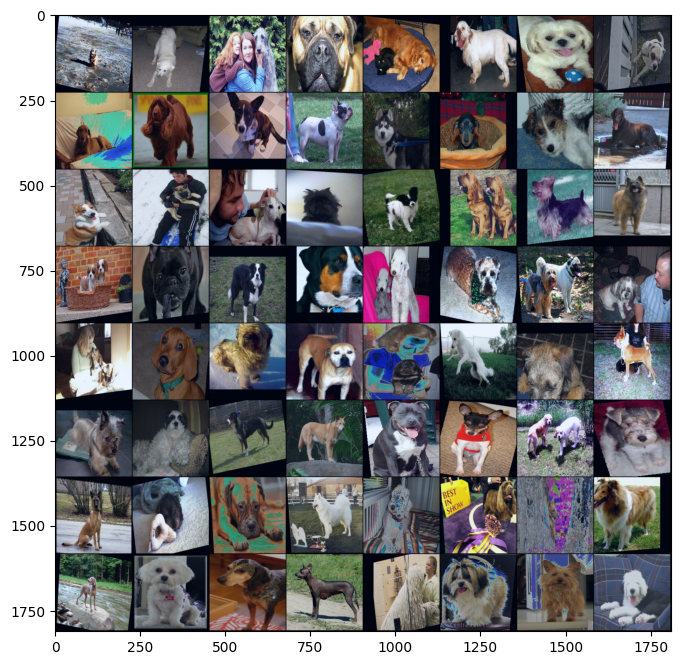

In [14]:
x, y = next(iter(train_loader))
img_grid = make_grid(x, nrow=8, normalize=True).permute(1, 2, 0)

plt.figure(figsize=(16, 8))
plt.imshow(img_grid)

### Training a model from scratch

In [18]:
def efficientnet_model(efficient):
  model = efficient(dropout=0.4)
  in_features = model.classifier[1].in_features
  model.classifier[1] = nn.Linear(in_features, 120)

  return model

In [20]:
model = efficientnet_model(models.efficientnet_b0).to(device)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [22]:
def train (model,loader,critation,optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = critation(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    train_loss = running_loss / len(loader)
    train_accuracy = correct / total
    
    
    return train_loss, train_accuracy

In [23]:
def evaluation (model,loader,critation):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = critation(outputs, targets)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    valid_loss = running_loss / len(loader)
    valid_accuracy = correct / total

    return valid_loss, valid_accuracy

In [24]:
num_epochs = 40

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in tqdm(range(num_epochs)):
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer)
    test_loss, test_accuracy = evaluation(model, test_loader, criterion)  

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    # if epoch % 10 == 0:
    print(f"Epoch {epoch + 1}/{num_epochs}:")
    print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.4f}")
    print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_accuracy:.4f}")
    print()


  2%|▎         | 1/40 [03:54<2:32:12, 234.17s/it]

Epoch 1/40:
Train Loss: 4.8300 | Train Accuracy: 0.0100
Test Loss: 4.6770 | Test Accuracy: 0.0231



  5%|▌         | 2/40 [07:49<2:28:49, 235.00s/it]

Epoch 2/40:
Train Loss: 4.6400 | Train Accuracy: 0.0184
Test Loss: 4.5158 | Test Accuracy: 0.0280



  8%|▊         | 3/40 [10:16<2:00:01, 194.64s/it]

Epoch 3/40:
Train Loss: 4.5003 | Train Accuracy: 0.0290
Test Loss: 4.4099 | Test Accuracy: 0.0310



 10%|█         | 4/40 [12:45<1:46:07, 176.86s/it]

Epoch 4/40:
Train Loss: 4.3556 | Train Accuracy: 0.0391
Test Loss: 4.2470 | Test Accuracy: 0.0416



 12%|█▎        | 5/40 [18:24<2:17:06, 235.04s/it]

Epoch 5/40:
Train Loss: 4.2090 | Train Accuracy: 0.0503
Test Loss: 4.0929 | Test Accuracy: 0.0624



 15%|█▌        | 6/40 [21:47<2:07:00, 224.13s/it]

Epoch 6/40:
Train Loss: 4.0888 | Train Accuracy: 0.0591
Test Loss: 3.9401 | Test Accuracy: 0.0739



 18%|█▊        | 7/40 [24:45<1:55:05, 209.25s/it]

Epoch 7/40:
Train Loss: 3.9979 | Train Accuracy: 0.0726
Test Loss: 3.8731 | Test Accuracy: 0.0850



 20%|██        | 8/40 [27:49<1:47:18, 201.19s/it]

Epoch 8/40:
Train Loss: 3.8867 | Train Accuracy: 0.0828
Test Loss: 3.8324 | Test Accuracy: 0.0833



 22%|██▎       | 9/40 [31:06<1:43:11, 199.71s/it]

Epoch 9/40:
Train Loss: 3.8073 | Train Accuracy: 0.0975
Test Loss: 3.6447 | Test Accuracy: 0.1164



 25%|██▌       | 10/40 [37:42<2:10:12, 260.43s/it]

Epoch 10/40:
Train Loss: 3.6927 | Train Accuracy: 0.1105
Test Loss: 3.5862 | Test Accuracy: 0.1145



 28%|██▊       | 11/40 [41:56<2:04:53, 258.38s/it]

Epoch 11/40:
Train Loss: 3.5725 | Train Accuracy: 0.1298
Test Loss: 3.4684 | Test Accuracy: 0.1323



 30%|███       | 12/40 [46:40<2:04:10, 266.10s/it]

Epoch 12/40:
Train Loss: 3.4403 | Train Accuracy: 0.1560
Test Loss: 3.5587 | Test Accuracy: 0.1343



 32%|███▎      | 13/40 [52:12<2:08:44, 286.09s/it]

Epoch 13/40:
Train Loss: 3.3085 | Train Accuracy: 0.1713
Test Loss: 3.3336 | Test Accuracy: 0.1633



 35%|███▌      | 14/40 [55:09<1:49:46, 253.32s/it]

Epoch 14/40:
Train Loss: 3.1862 | Train Accuracy: 0.1915
Test Loss: 3.1603 | Test Accuracy: 0.1995



 38%|███▊      | 15/40 [58:32<1:39:13, 238.14s/it]

Epoch 15/40:
Train Loss: 3.0608 | Train Accuracy: 0.2192
Test Loss: 3.1628 | Test Accuracy: 0.2064



 40%|████      | 16/40 [1:01:24<1:27:19, 218.30s/it]

Epoch 16/40:
Train Loss: 2.9228 | Train Accuracy: 0.2461
Test Loss: 2.8428 | Test Accuracy: 0.2542



 42%|████▎     | 17/40 [1:04:24<1:19:10, 206.54s/it]

Epoch 17/40:
Train Loss: 2.7917 | Train Accuracy: 0.2675
Test Loss: 2.7808 | Test Accuracy: 0.2748



 45%|████▌     | 18/40 [1:07:05<1:10:48, 193.10s/it]

Epoch 18/40:
Train Loss: 2.6552 | Train Accuracy: 0.2955
Test Loss: 2.8382 | Test Accuracy: 0.2589



 48%|████▊     | 19/40 [1:10:03<1:05:59, 188.53s/it]

Epoch 19/40:
Train Loss: 2.5469 | Train Accuracy: 0.3226
Test Loss: 2.7166 | Test Accuracy: 0.2950



 50%|█████     | 20/40 [1:12:33<59:00, 177.01s/it]  

Epoch 20/40:
Train Loss: 2.4160 | Train Accuracy: 0.3455
Test Loss: 2.7566 | Test Accuracy: 0.2927



 52%|█████▎    | 21/40 [1:15:13<54:21, 171.63s/it]

Epoch 21/40:
Train Loss: 2.2955 | Train Accuracy: 0.3739
Test Loss: 2.5957 | Test Accuracy: 0.3113



 55%|█████▌    | 22/40 [1:17:52<50:25, 168.11s/it]

Epoch 22/40:
Train Loss: 2.2069 | Train Accuracy: 0.3891
Test Loss: 2.6363 | Test Accuracy: 0.3139



 57%|█████▊    | 23/40 [1:21:31<51:56, 183.35s/it]

Epoch 23/40:
Train Loss: 2.0804 | Train Accuracy: 0.4211
Test Loss: 2.5066 | Test Accuracy: 0.3498



 60%|██████    | 24/40 [1:25:05<51:19, 192.49s/it]

Epoch 24/40:
Train Loss: 1.9865 | Train Accuracy: 0.4377
Test Loss: 2.5994 | Test Accuracy: 0.3385



 62%|██████▎   | 25/40 [1:28:01<46:54, 187.64s/it]

Epoch 25/40:
Train Loss: 1.8817 | Train Accuracy: 0.4707
Test Loss: 2.4564 | Test Accuracy: 0.3610



 65%|██████▌   | 26/40 [1:31:14<44:09, 189.23s/it]

Epoch 26/40:
Train Loss: 1.8065 | Train Accuracy: 0.4924
Test Loss: 2.4204 | Test Accuracy: 0.3808



 68%|██████▊   | 27/40 [1:34:09<40:01, 184.77s/it]

Epoch 27/40:
Train Loss: 1.7125 | Train Accuracy: 0.5052
Test Loss: 2.4386 | Test Accuracy: 0.3728



 70%|███████   | 28/40 [1:37:38<38:26, 192.18s/it]

Epoch 28/40:
Train Loss: 1.6364 | Train Accuracy: 0.5239
Test Loss: 2.4298 | Test Accuracy: 0.3836



 72%|███████▎  | 29/40 [1:40:24<33:47, 184.33s/it]

Epoch 29/40:
Train Loss: 1.5384 | Train Accuracy: 0.5515
Test Loss: 2.5093 | Test Accuracy: 0.3875



 75%|███████▌  | 30/40 [1:43:17<30:08, 180.88s/it]

Epoch 30/40:
Train Loss: 1.4679 | Train Accuracy: 0.5728
Test Loss: 2.4802 | Test Accuracy: 0.3824



 78%|███████▊  | 31/40 [1:46:34<27:52, 185.79s/it]

Epoch 31/40:
Train Loss: 1.3818 | Train Accuracy: 0.5907
Test Loss: 2.7393 | Test Accuracy: 0.3668



 80%|████████  | 32/40 [1:49:05<23:23, 175.39s/it]

Epoch 32/40:
Train Loss: 1.3084 | Train Accuracy: 0.6132
Test Loss: 2.4758 | Test Accuracy: 0.3935



 82%|████████▎ | 33/40 [1:51:24<19:10, 164.36s/it]

Epoch 33/40:
Train Loss: 1.2793 | Train Accuracy: 0.6252
Test Loss: 2.5629 | Test Accuracy: 0.3875



 85%|████████▌ | 34/40 [1:53:47<15:46, 157.83s/it]

Epoch 34/40:
Train Loss: 1.1806 | Train Accuracy: 0.6523
Test Loss: 2.5762 | Test Accuracy: 0.3824



 88%|████████▊ | 35/40 [1:57:31<14:48, 177.78s/it]

Epoch 35/40:
Train Loss: 1.1389 | Train Accuracy: 0.6643
Test Loss: 2.6286 | Test Accuracy: 0.3850



 90%|█████████ | 36/40 [2:00:24<11:45, 176.36s/it]

Epoch 36/40:
Train Loss: 1.0818 | Train Accuracy: 0.6773
Test Loss: 2.7402 | Test Accuracy: 0.3810



 92%|█████████▎| 37/40 [2:02:58<08:28, 169.54s/it]

Epoch 37/40:
Train Loss: 1.0028 | Train Accuracy: 0.7027
Test Loss: 2.6574 | Test Accuracy: 0.3960



 95%|█████████▌| 38/40 [2:05:51<05:41, 170.62s/it]

Epoch 38/40:
Train Loss: 0.9545 | Train Accuracy: 0.7138
Test Loss: 2.7281 | Test Accuracy: 0.3880



 98%|█████████▊| 39/40 [2:09:19<03:01, 181.93s/it]

Epoch 39/40:
Train Loss: 0.9056 | Train Accuracy: 0.7288
Test Loss: 2.7642 | Test Accuracy: 0.3938



100%|██████████| 40/40 [2:13:37<00:00, 200.44s/it]

Epoch 40/40:
Train Loss: 0.8838 | Train Accuracy: 0.7333
Test Loss: 2.6890 | Test Accuracy: 0.4075



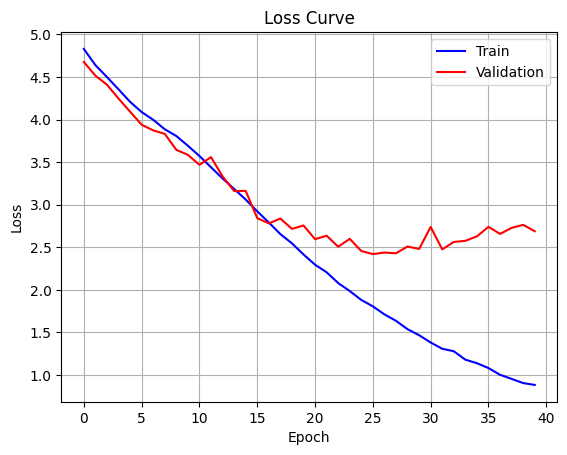

In [25]:
plt.plot(range(num_epochs), train_losses, 'b-', label='Train')
plt.plot(range(num_epochs), test_losses, 'r-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.grid(True)
plt.legend()

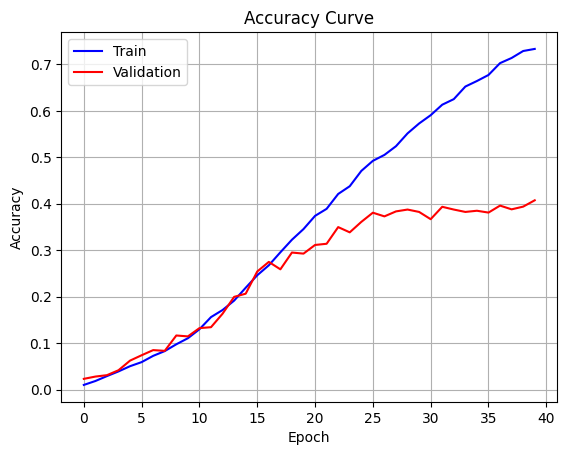

In [26]:
plt.plot(range(num_epochs), train_accuracies, 'b-', label='Train')
plt.plot(range(num_epochs), test_accuracies, 'r-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.grid(True)
plt.legend()

### Transfer learning from pre-trained weights

In [27]:
def freezed_efficientnet_model(efficient, efficient_weights):
    model = efficient(weights=efficient_weights)
    for p in model.parameters():
        p.requires_grad = False
    in_features = model.classifier[1].in_features
      
    model.classifier = nn.Sequential(
        nn.BatchNorm1d(in_features),
        nn.Dropout(0.2),
        nn.Linear(in_features, 120)
    )

    return model.to(device)


In [28]:
freezed_model = freezed_efficientnet_model(models.efficientnet_b0,models.EfficientNet_B0_Weights.IMAGENET1K_V1).to(device)
freezed_model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [29]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(freezed_model.parameters(), lr=1e-2)

In [30]:
num_epochs = 25

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in tqdm(range(num_epochs)):
    train_loss, train_accuracy = train(freezed_model, train_loader, criterion, optimizer)
    test_loss, test_accuracy = evaluation(freezed_model, test_loader, criterion)  

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    # if epoch % 10 == 0:
    print(f"Epoch {epoch + 1}/{num_epochs}:")
    print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.4f}")
    print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_accuracy:.4f}")
    print()


  0%|          | 0/25 [00:00<?, ?it/s]

  4%|▍         | 1/25 [02:38<1:03:31, 158.83s/it]

Epoch 1/25:
Train Loss: 3.1055 | Train Accuracy: 0.4202
Test Loss: 1.5828 | Test Accuracy: 0.6282



  8%|▊         | 2/25 [04:59<56:41, 147.89s/it]  

Epoch 2/25:
Train Loss: 1.5627 | Train Accuracy: 0.6106
Test Loss: 1.2811 | Test Accuracy: 0.6713



 12%|█▏        | 3/25 [06:58<49:28, 134.92s/it]

Epoch 3/25:
Train Loss: 1.2289 | Train Accuracy: 0.6639
Test Loss: 1.2937 | Test Accuracy: 0.6690



 16%|█▌        | 4/25 [10:15<55:47, 159.39s/it]

Epoch 4/25:
Train Loss: 1.1072 | Train Accuracy: 0.6928
Test Loss: 1.2908 | Test Accuracy: 0.6661



 20%|██        | 5/25 [12:19<48:55, 146.78s/it]

Epoch 5/25:
Train Loss: 1.0703 | Train Accuracy: 0.6993
Test Loss: 1.3018 | Test Accuracy: 0.6669



 24%|██▍       | 6/25 [15:04<48:23, 152.82s/it]

Epoch 6/25:
Train Loss: 1.0154 | Train Accuracy: 0.7145
Test Loss: 1.3057 | Test Accuracy: 0.6703



 28%|██▊       | 7/25 [17:31<45:18, 151.03s/it]

Epoch 7/25:
Train Loss: 1.0073 | Train Accuracy: 0.7193
Test Loss: 1.3018 | Test Accuracy: 0.6786



 32%|███▏      | 8/25 [21:05<48:27, 171.02s/it]

Epoch 8/25:
Train Loss: 0.9846 | Train Accuracy: 0.7214
Test Loss: 1.3539 | Test Accuracy: 0.6749



 36%|███▌      | 9/25 [24:33<48:38, 182.41s/it]

Epoch 9/25:
Train Loss: 0.9674 | Train Accuracy: 0.7283
Test Loss: 1.3956 | Test Accuracy: 0.6655



 40%|████      | 10/25 [27:41<46:03, 184.27s/it]

Epoch 10/25:
Train Loss: 0.9708 | Train Accuracy: 0.7317
Test Loss: 1.3988 | Test Accuracy: 0.6760



 44%|████▍     | 11/25 [30:52<43:29, 186.40s/it]

Epoch 11/25:
Train Loss: 0.9622 | Train Accuracy: 0.7368
Test Loss: 1.4224 | Test Accuracy: 0.6657



 48%|████▊     | 12/25 [33:39<39:07, 180.54s/it]

Epoch 12/25:
Train Loss: 0.9614 | Train Accuracy: 0.7382
Test Loss: 1.4385 | Test Accuracy: 0.6692



 52%|█████▏    | 13/25 [35:37<32:18, 161.52s/it]

Epoch 13/25:
Train Loss: 0.9435 | Train Accuracy: 0.7417
Test Loss: 1.4360 | Test Accuracy: 0.6714



 56%|█████▌    | 14/25 [39:52<34:48, 189.83s/it]

Epoch 14/25:
Train Loss: 0.9616 | Train Accuracy: 0.7373
Test Loss: 1.4841 | Test Accuracy: 0.6618



 60%|██████    | 15/25 [42:28<29:54, 179.48s/it]

Epoch 15/25:
Train Loss: 0.9459 | Train Accuracy: 0.7475
Test Loss: 1.4239 | Test Accuracy: 0.6723



 64%|██████▍   | 16/25 [44:22<23:59, 159.91s/it]

Epoch 16/25:
Train Loss: 0.9331 | Train Accuracy: 0.7462
Test Loss: 1.4292 | Test Accuracy: 0.6760



 68%|██████▊   | 17/25 [46:18<19:32, 146.57s/it]

Epoch 17/25:
Train Loss: 0.9430 | Train Accuracy: 0.7502
Test Loss: 1.4281 | Test Accuracy: 0.6720



 72%|███████▏  | 18/25 [48:34<16:44, 143.54s/it]

Epoch 18/25:
Train Loss: 0.9115 | Train Accuracy: 0.7529
Test Loss: 1.4937 | Test Accuracy: 0.6688



 76%|███████▌  | 19/25 [50:31<13:32, 135.33s/it]

Epoch 19/25:
Train Loss: 0.9499 | Train Accuracy: 0.7515
Test Loss: 1.5391 | Test Accuracy: 0.6672



 80%|████████  | 20/25 [52:42<11:11, 134.21s/it]

Epoch 20/25:
Train Loss: 0.9388 | Train Accuracy: 0.7499
Test Loss: 1.5598 | Test Accuracy: 0.6653



 84%|████████▍ | 21/25 [54:42<08:39, 129.79s/it]

Epoch 21/25:
Train Loss: 0.9528 | Train Accuracy: 0.7465
Test Loss: 1.5366 | Test Accuracy: 0.6671



 88%|████████▊ | 22/25 [56:40<06:18, 126.29s/it]

Epoch 22/25:
Train Loss: 0.9658 | Train Accuracy: 0.7424
Test Loss: 1.5866 | Test Accuracy: 0.6635



 92%|█████████▏| 23/25 [58:41<04:09, 124.88s/it]

Epoch 23/25:
Train Loss: 0.9458 | Train Accuracy: 0.7509
Test Loss: 1.5385 | Test Accuracy: 0.6698



 96%|█████████▌| 24/25 [1:01:29<02:17, 137.63s/it]

Epoch 24/25:
Train Loss: 0.9694 | Train Accuracy: 0.7472
Test Loss: 1.5508 | Test Accuracy: 0.6669



100%|██████████| 25/25 [1:03:35<00:00, 152.62s/it]

Epoch 25/25:
Train Loss: 0.9228 | Train Accuracy: 0.7592
Test Loss: 1.5963 | Test Accuracy: 0.6640



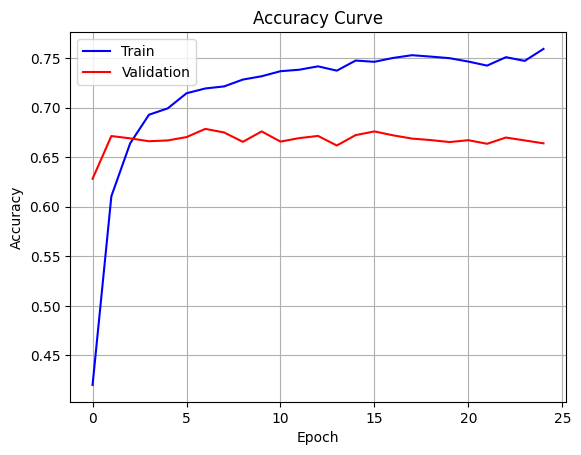

In [32]:
plt.plot(range(num_epochs), train_accuracies, 'b-', label='Train')
plt.plot(range(num_epochs), test_accuracies, 'r-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.grid(True)
plt.legend()

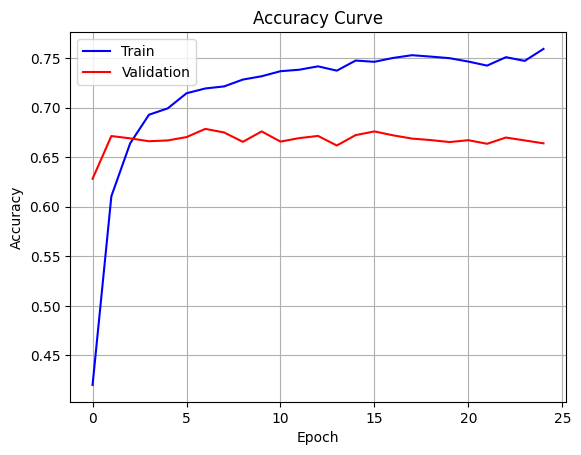

In [33]:
plt.plot(range(num_epochs), train_accuracies, 'b-', label='Train')
plt.plot(range(num_epochs), test_accuracies, 'r-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.grid(True)
plt.legend()

In [34]:

top_layers=20
layer_count = 0


for name, param in freezed_model.named_parameters():
    if not isinstance(param, nn.BatchNorm2d):
        param.requires_grad = True
        layer_count += 1
        if layer_count >= top_layers:
            break
    else:
        param.requires_grad = False


optimizer = optim.Adam(filter(lambda p: p.requires_grad, freezed_model.parameters()), lr=1e-5)
criterion = nn.CrossEntropyLoss()
    
    

In [35]:
num_epochs = 4

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in tqdm(range(num_epochs)):
    train_loss, train_accuracy = train(freezed_model, train_loader, criterion, optimizer)
    test_loss, test_accuracy = evaluation(freezed_model, test_loader, criterion)  

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    # if epoch % 10 == 0:
    print(f"Epoch {epoch + 1}/{num_epochs}:")
    print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.4f}")
    print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_accuracy:.4f}")
    print()


 25%|██▌       | 1/4 [02:27<07:23, 147.90s/it]

Epoch 1/4:
Train Loss: 0.8161 | Train Accuracy: 0.7798
Test Loss: 1.5983 | Test Accuracy: 0.6608



 50%|█████     | 2/4 [05:04<05:06, 153.01s/it]

Epoch 2/4:
Train Loss: 0.8167 | Train Accuracy: 0.7831
Test Loss: 1.5931 | Test Accuracy: 0.6610



 75%|███████▌  | 3/4 [07:47<02:37, 157.58s/it]

Epoch 3/4:
Train Loss: 0.7985 | Train Accuracy: 0.7829
Test Loss: 1.5914 | Test Accuracy: 0.6605



100%|██████████| 4/4 [10:31<00:00, 157.76s/it]

Epoch 4/4:
Train Loss: 0.7894 | Train Accuracy: 0.7850
Test Loss: 1.5420 | Test Accuracy: 0.6705



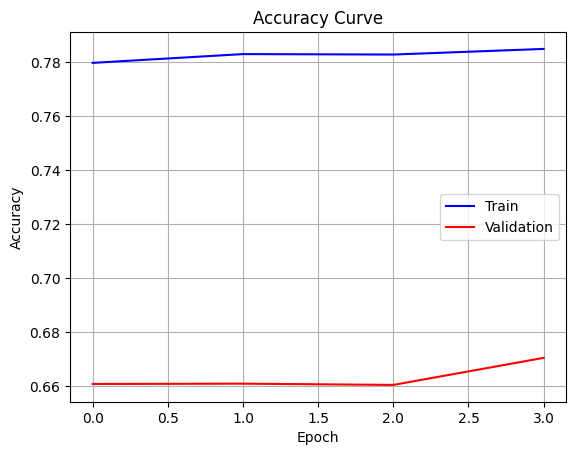

In [36]:
plt.plot(range(num_epochs), train_accuracies, 'b-', label='Train')
plt.plot(range(num_epochs), test_accuracies, 'r-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.grid(True)
plt.legend()

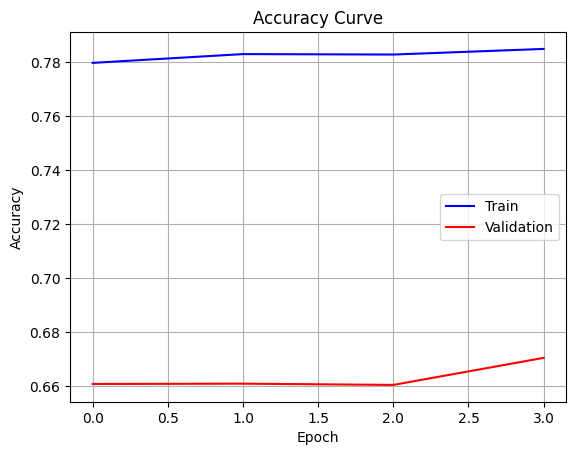

In [37]:
plt.plot(range(num_epochs), train_accuracies, 'b-', label='Train')
plt.plot(range(num_epochs), test_accuracies, 'r-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.grid(True)
plt.legend()